In [1]:
# Augmenting Image Supporting Library
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import random
import skimage as sk
from PIL import Image
from scipy import ndarray
from tqdm import tqdm

import seaborn as sb
sb.set()

import torch

# Deep Learning Supporting Library
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Check if MPS is available
# MPS is for pytorch to leverage on M1 GPU
torch.device("mps")
print(torch.backends.mps.is_built() and torch.backends.mps.is_available())


# Check if GPU is available
print("GPU is", "\033[92mavailable" if tf.config.list_physical_devices('GPU') else "\033[91mNOT AVAILABLE")

True
GPU is available


In [ ]:
# Functions

def get_num_of_images(path : str):
    path  = path 
    classes = os.listdir(path)
    folder_name = os.path.basename(path)
    for category in classes:

        if category == '.DS_Store':
            continue
        # Print the number of photos in each folder
        return len(os.listdir(path + "/" + category))

def __crop_square(image_array : ndarray, size: int):
    # Using skimage to crop the photo as a square
    min_dim = min(image_array.shape[:2])
    center = np.array(image_array.shape[:2]) / 2.0
    half_size = min_dim / 2.0
    start = np.round(center - half_size)
    end = np.round(center + half_size)
    cropped_image = image_array[int(start[0]):int(end[0]), int(start[1]):int(end[1])]

    # Get the aspect ratio of the original image
    aspect_ratio = cropped_image.shape[1] / cropped_image.shape[0]
    # Calculate the new size with 256 as the maximum dimension
    new_size = (size, int(size * aspect_ratio)) if aspect_ratio > 1 else (int(size / aspect_ratio), size)
    
    # Resize the image
    return sk.transform.resize(cropped_image, new_size)

def mass_crop_square(source: str, destination_path: str, size: int):

    # Get all the images in the folder as an array
    images = [os.path.join(source, f) for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]

    if len(os.listdir(destination_path)) > 0:
        print('Destination path contains other files')
        return
    
    # Loop through the images
    for image_path in tqdm(images, ascii=True, desc='ඞ'):
        # Read the image as an array of pixels
        image_to_transform = sk.io.imread(image_path)
        # Get the file name
        file_name = image_path.split('/')[-1]
        # Get the file extension
        file_extension = file_name.split('.')[-1]
        # Apply the transformation and crop the image as a square of 256x256
        transformed_image = (__crop_square(image_to_transform, size)*255).astype(np.uint8)
        # Define the path to the new file
        new_file_path = '{}{}.{}'.format(destination_path, file_name, file_extension)
        # Write the image to the disk
        sk.io.imsave(new_file_path, transformed_image)


def printing_samples(ds : tf.data.Dataset):
    class_names = ds.class_names

    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):
        for i in range(3):
            ax = plt.subplot(1, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i])])
            plt.axis("off")

def aug_printing_samples(ds : tf.keras.preprocessing.image.ImageDataGenerator):
    class_dictionary = ds.class_indices
    class_dictionary = { value:key for key,value in class_dictionary.items()}
    class_list = [value for _,value in class_dictionary.items()]

    image_batch = ds.next()

    plt.figure(figsize=(10, 10))
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image_batch[0][i].astype("uint8"))
        plt.title(class_list[np.argmax(ds.next()[1][i])])
        plt.axis("off")


def _confusion_matrix(model, dataset: tf.data.Dataset):
    y_true = np.array([])
    y_pred = np.array([])

    for images, labels in dataset:
        y_pred = np.concatenate([y_pred,np.argmax(model.predict(images, verbose=0), axis=-1)])
        y_true = np.concatenate([y_true,np.argmax(labels.numpy(), axis=-1)])

    return confusion_matrix(y_true, y_pred), classification_report(y_true, y_pred, target_names=dataset.class_names)


def _augment_confusion_matrix(model, dataset: tf.keras.preprocessing.image.ImageDataGenerator):
    class_dictionary = dataset.class_indices
    class_dictionary = { value:key for key,value in class_dictionary.items()}
    class_list = [value for _,value in class_dictionary.items()]
    y_true = np.array([])
    y_pred = np.array([])


    y_pred = np.concatenate([y_pred,np.argmax(model.predict_generator(dataset, verbose=0), axis=-1)])
    y_true = np.concatenate([y_true,dataset.classes])

    return confusion_matrix(y_true, y_pred), classification_report(y_true, y_pred, target_names=class_list)


In [ ]:
# Loading of image data
training_set = tf.keras.utils.image_dataset_from_directory(crop_dir+'train/',
                                                            labels = "inferred",
                                                            label_mode = "categorical",
                                                            color_mode = "rgb",
                                                            batch_size = 32,
                                                            image_size = (256,256),
                                                            seed = 1234)

validation_set = tf.keras.utils.image_dataset_from_directory(crop_dir+'val/',
                                                            labels = "inferred",
                                                            label_mode = "categorical",
                                                            color_mode = "rgb",
                                                            batch_size = 32,
                                                            image_size = (256,256),
                                                            seed = 1234)
test_set = tf.keras.utils.image_dataset_from_directory(crop_dir+'test/',
                                                            labels = "inferred",
                                                            label_mode = "categorical",
                                                            color_mode = "rgb",
                                                            batch_size = 32,
                                                            image_size = (256,256),
                                                            seed = 1234)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


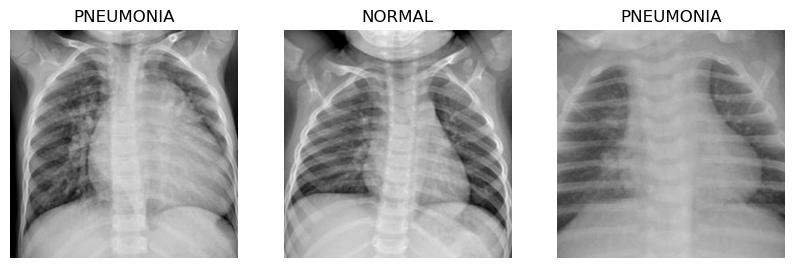

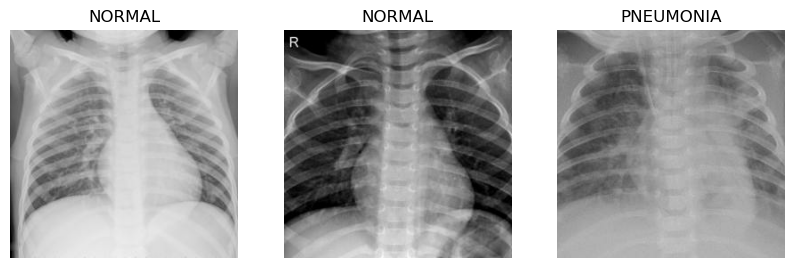

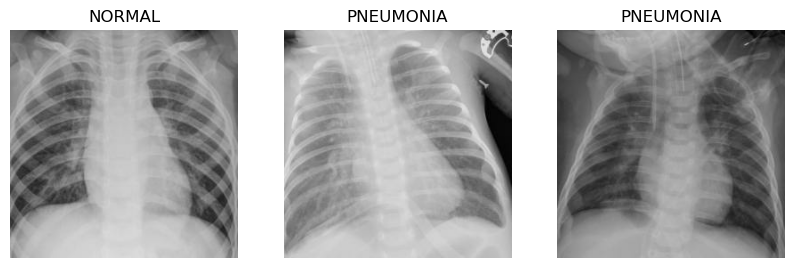

In [ ]:
# Visualise the images
printing_samples(training_set)
printing_samples(validation_set)
printing_samples(test_set)


In [ ]:
optimizer = Adam(learning_rate=1e-4)
lrs = tf.keras.callbacks.ReduceLROnPlateau()
loss = tf.keras.losses.CategoricalCrossentropy()
int_lr = 0.0001
epoch = 30
batch_size = 32

# Early Stopping helps to stop the training process when the model stops improving. This is to reduce the amount of time needed to train over nuance changes in the model. 
early_stoppage = EarlyStopping(monitor='val_loss', patience=10)

We are leveraging on transfer learning to create our model as we do not have enough data to train a model from scratch. Transfer learning helps us to use a pre-trained model and fine-tune it to our dataset. 

We will be taking layers from a denseNet121 model, freeze a portion of the layers to avoid destroying any information they contain and add our own layers to the model. By adding our own layers, we are able to fine-tune the model to our dataset.

In [ ]:
# DenseNet Model

densed_Model = DenseNet121(include_top=False,input_tensor= tf.keras.Input(shape=(256,256,3)), weights='imagenet')


# Freeze the layers
for layer in densed_Model.layers[:101]:    
    layer.trainable = False

for layer in densed_Model.layers[101:]:  
    layer.trainable = True

# model = tf.keras.Sequential()
# model.add(densed_Model)
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(256, activation='relu'))
# # Drop out is used to prevent overfitting. It randomly drops out a percentage of the nodes in the layer. This helps to prevent the model from learning the noise in the data.
# model.add(Dropout(0.7))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))

model = tf.keras.Sequential()
model.add(densed_Model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))




In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(training_set, epochs=epoch, validation_data=validation_set, callbacks=[early_stoppage,lrs])

model.summary()

model.save('./aug/denseNet121/denseNetModel.h5')
model.save_weights('./model/denseNet121/denseNetWeights.h5')


Epoch 1/30


2023-03-23 22:52:26.687970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8706

2023-03-23 22:54:23.054932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 127s 632ms/step - loss: 0.3366 - accuracy: 0.8706 - val_loss: 0.3662 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/30
163/163 [==============================] - 81s 489ms/step - loss: 0.1365 - accuracy: 0.9636 - val_loss: 0.4783 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/30
163/163 [==============================] - 77s 471ms/step - loss: 0.0972 - accuracy: 0.9716 - val_loss: 0.4573 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/30
163/163 [==============================] - 77s 474ms/step - loss: 0.0694 - accuracy: 0.9827 - val_loss: 0.3385 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 5/30
163/163 [==============================] - 78s 477ms/step - loss: 0.0518 - accuracy: 0.9854 - val_loss: 0.2080 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 6/30
163/163 [==============================] - 77s 475ms/step - loss: 0.0381 - accuracy: 0.9906 - val_loss: 0.3820 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 7/30
163/163 [==================

In [ ]:
model.history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


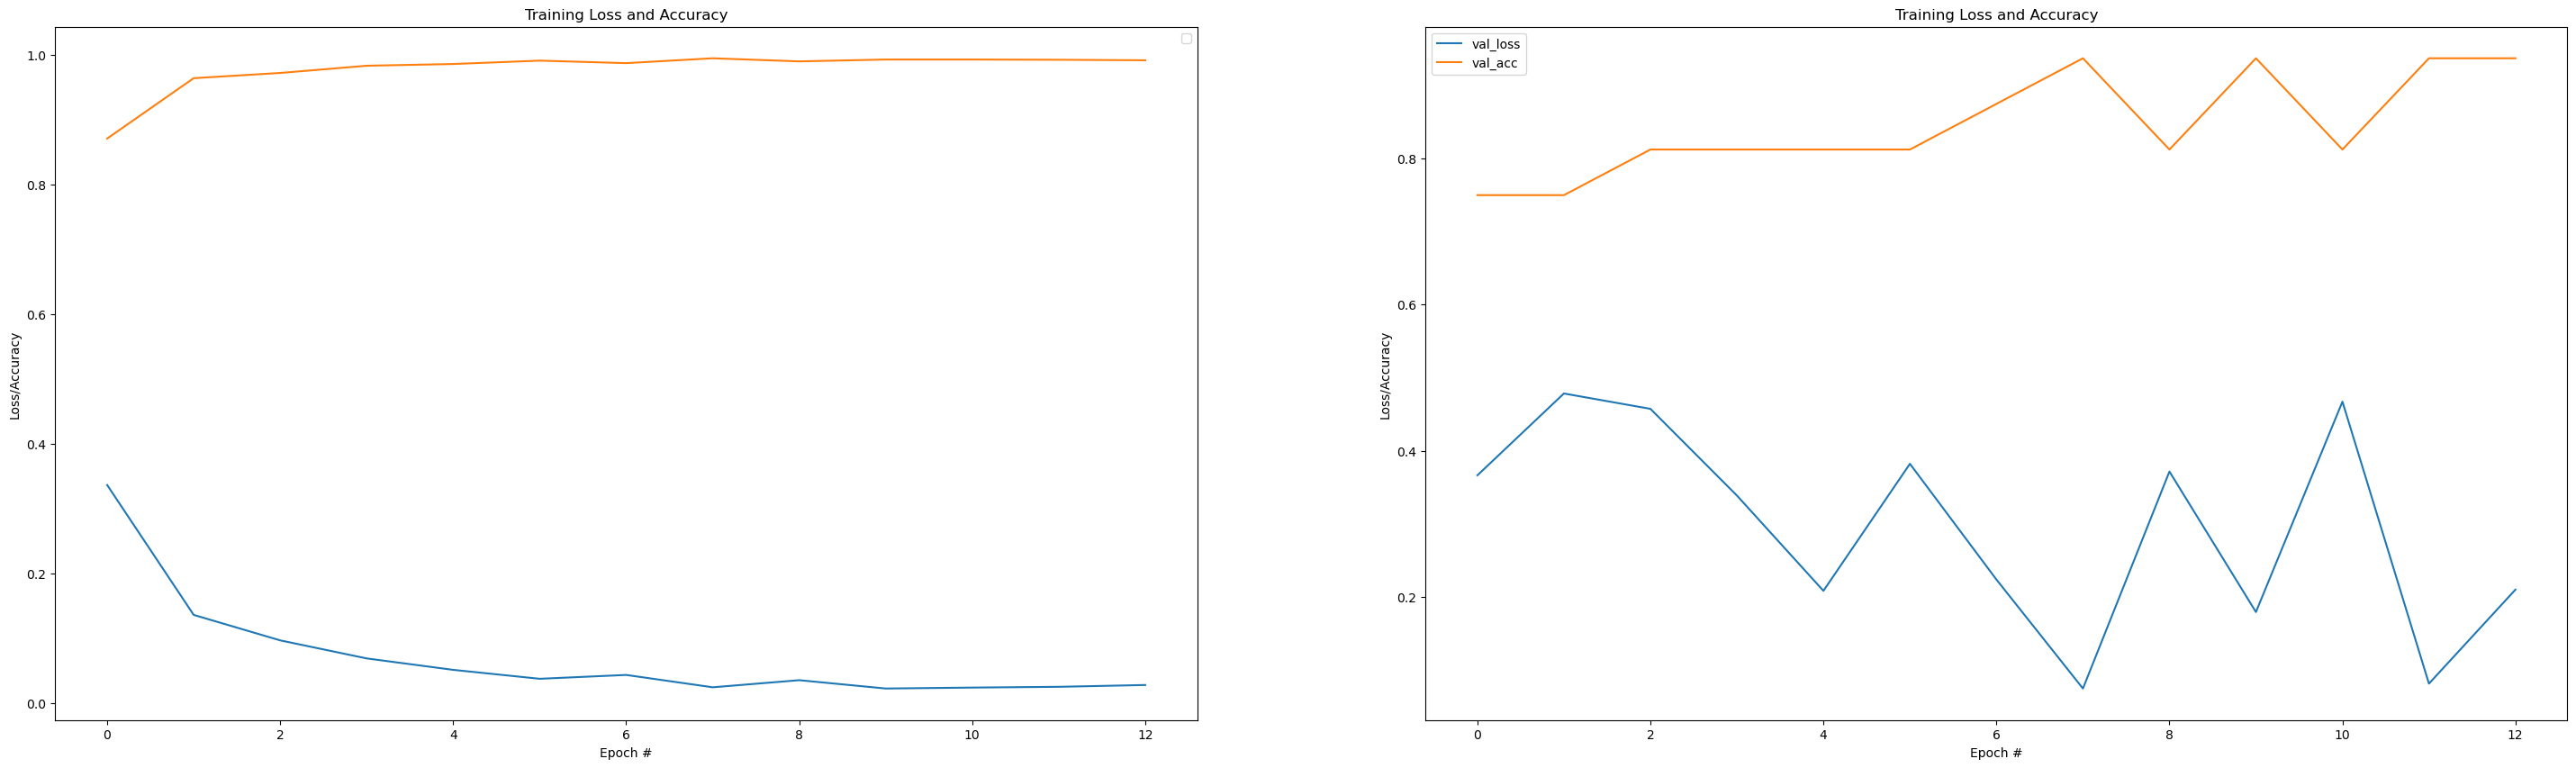

In [ ]:
# Plotting the loss and accuracy
iteration = np.arange(0, 13)

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["loss"], label="train_loss")
plt.plot(iteration, model.history.history["accuracy"], label="train_acc")
plt.legend()


ax = plt.subplot(1, 2, 2)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["val_loss"], label="val_loss")
plt.plot(iteration, model.history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# load the model
model_load = tf.keras.models.load_model('./model/denseNet121/denseNetModel.h5')
model_load.load_weights('./model/denseNet121/denseNetWeights.h5')

# Evaluate the model
loss , accuracy = model_load.evaluate(test_set)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')


2023-03-23 23:32:19.224342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 19s 664ms/step - loss: 0.8933 - accuracy: 0.8061
Loss: 0.8933
Accuracy: 0.8061


In [ ]:

print(_confusion_matrix(model_load, test_set)[1])

2023-03-23 23:32:41.531367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-23 23:32:52.654825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      NORMAL       1.00      0.48      0.65       234
   PNEUMONIA       0.76      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.74      0.76       624
weighted avg       0.85      0.81      0.79       624



(0.0, 2.0, 2.0, 0.0)

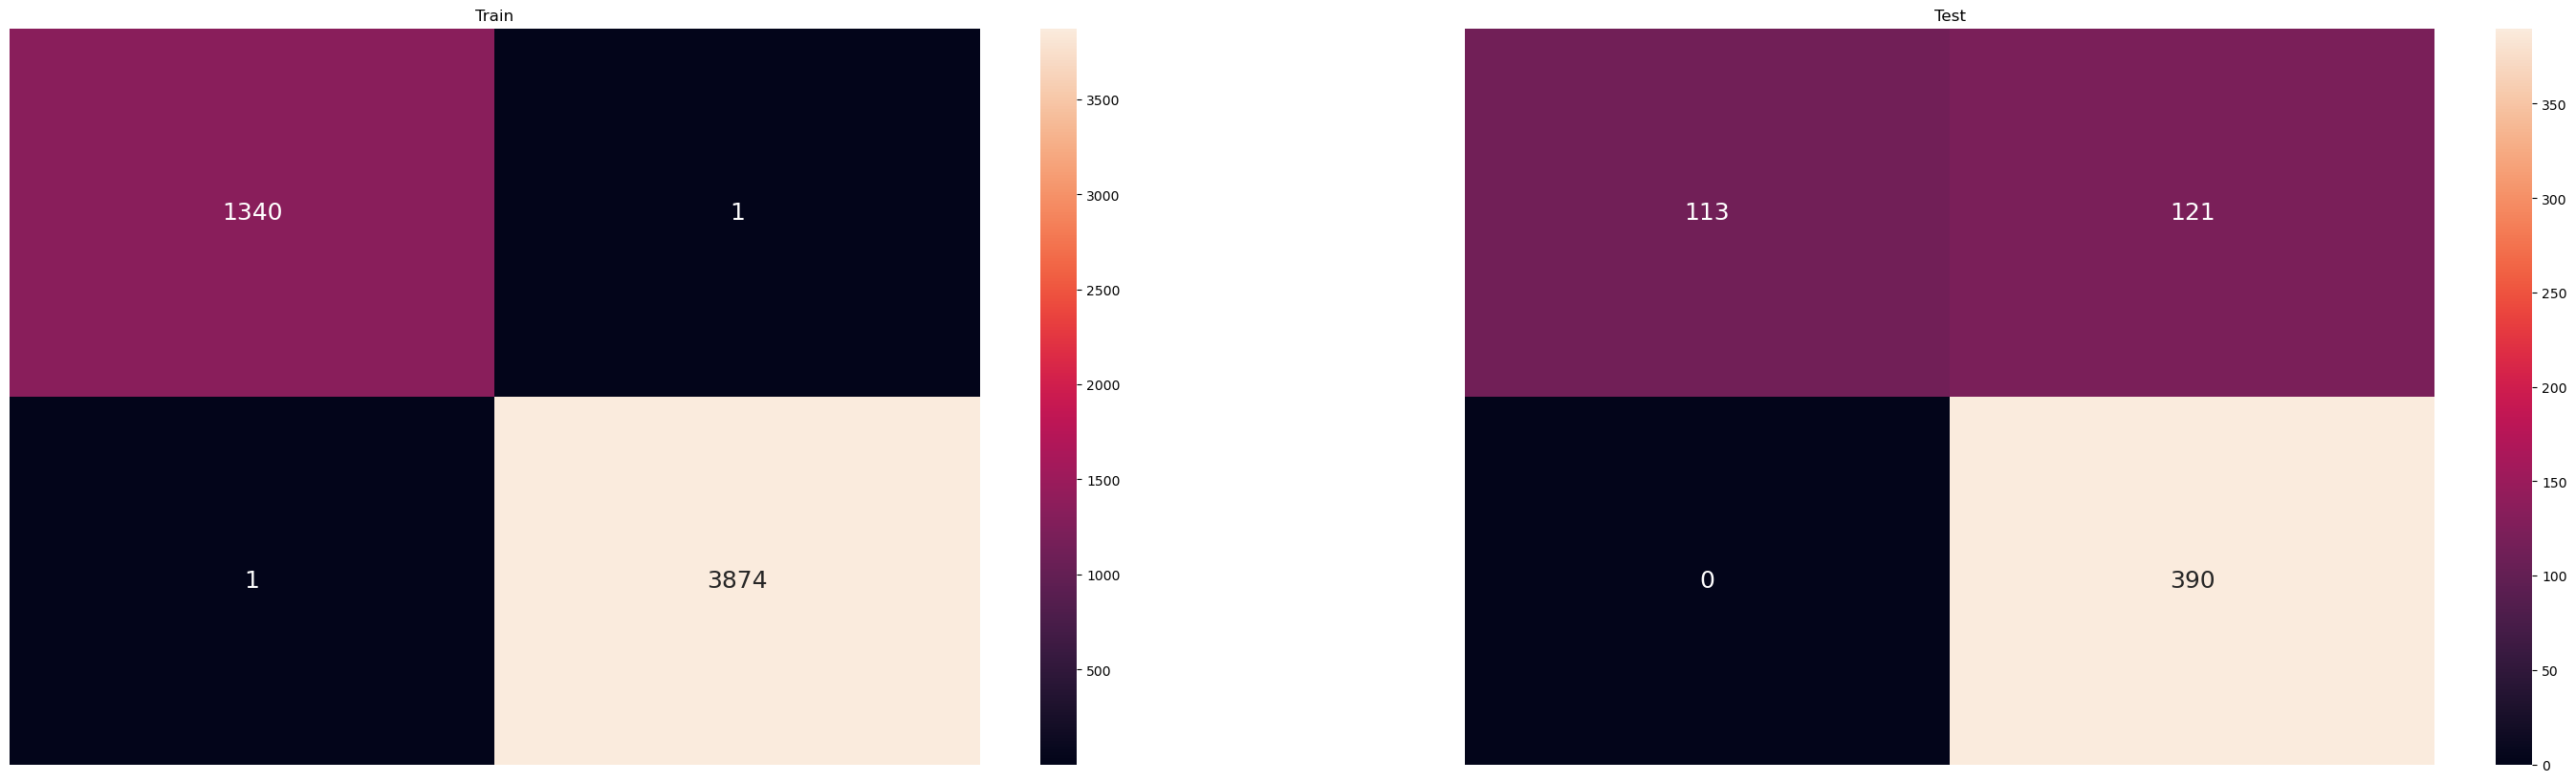

In [ ]:
plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)
plt.title("Train")
sb.heatmap(_confusion_matrix(model_load, training_set)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.title("Test")
sb.heatmap(_confusion_matrix(model_load, test_set)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

2023-03-23 23:34:17.065925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step


(-0.5, 255.5, 255.5, -0.5)

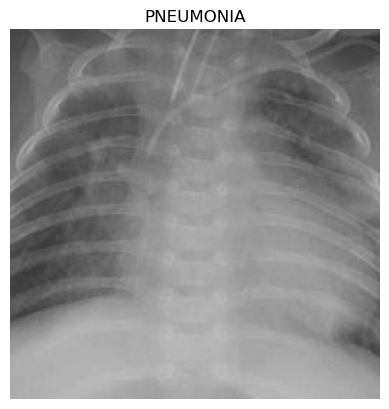

In [ ]:
image = tf.keras.utils.load_img("./crop_images/test/PNEUMONIA/person1_virus_8.jpeg.jpeg", target_size=(256, 256))

# load the model
model_load = tf.keras.models.load_model('./model/denseNet121/denseNetModel.h5')
model_load.load_weights('./model/denseNet121/denseNetWeights.h5')

preds = model_load.predict(np.expand_dims(image, axis=0))

i = preds.argmax(axis=1)[0]


plt.imshow(image)
plt.title(training_set.class_names[i])
plt.axis("off")

# <span style="background-color: #cc2f42"> Augmented Image Version ඞ </span>

We will be using the same model as above but with augmented images. This is to see if the model can learn more about the images and improve the accuracy.

In [ ]:
# Augment Image with ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False
)

# Generate the augmented images
augmented_train_ds = datagen.flow_from_directory(crop_dir+"/train",
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                seed=1234)

augmented_val_ds = datagen.flow_from_directory(crop_dir+"/val",
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                seed=1234)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


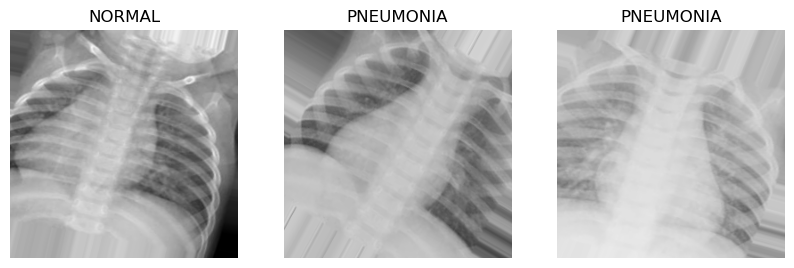

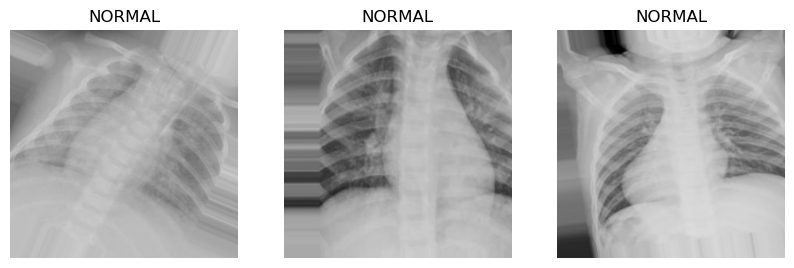

In [ ]:
# Visualise the augmented images
aug_printing_samples(augmented_train_ds)
aug_printing_samples(augmented_val_ds)


In [ ]:
optimizer = Adam(learning_rate=1e-4)
lrs = tf.keras.callbacks.ReduceLROnPlateau()
loss = tf.keras.losses.CategoricalCrossentropy()
int_lr = 0.0001
epoch = 30
batch_size = 32

# Early Stopping helps to stop the training process when the model stops improving. This is to reduce the amount of time needed to train over nuance changes in the model. 
early_stoppage = EarlyStopping(monitor='val_loss', patience=10)

# DenseNet Model

densed_Model = DenseNet121(include_top=False,input_tensor= tf.keras.Input(shape=(256,256,3)), weights='imagenet')


# Freeze the layers
for layer in densed_Model.layers[:149]:    
    layer.trainable = False

for layer in densed_Model.layers[149:]:  
    layer.trainable = True

# model = tf.keras.Sequential()
# model.add(densed_Model)
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(256, activation='relu'))
# # Drop out is used to prevent overfitting. It randomly drops out a percentage of the nodes in the layer. This helps to prevent the model from learning the noise in the data.
# model.add(Dropout(0.7))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))

model = tf.keras.Sequential()
model.add(densed_Model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(augmented_train_ds, epochs=epoch, validation_data=augmented_val_ds, callbacks=[lrs])

model.summary()

model.save('./augment_model/denseNet121/denseNetModel.h5')
model.save_weights('./augment_model/denseNet121/denseNetWeights.h5')


Epoch 1/30


2023-03-23 23:35:07.533864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.7107

2023-03-23 23:36:53.215198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 122s 571ms/step - loss: 0.5864 - accuracy: 0.7107 - val_loss: 0.5644 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/30
163/163 [==============================] - 75s 450ms/step - loss: 0.3121 - accuracy: 0.8708 - val_loss: 0.6497 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/30
163/163 [==============================] - 72s 437ms/step - loss: 0.2177 - accuracy: 0.9233 - val_loss: 0.6506 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 4/30
163/163 [==============================] - 66s 402ms/step - loss: 0.1720 - accuracy: 0.9452 - val_loss: 0.7924 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 5/30
163/163 [==============================] - 67s 409ms/step - loss: 0.1490 - accuracy: 0.9505 - val_loss: 0.9312 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 6/30
163/163 [==============================] - 62s 382ms/step - loss: 0.1419 - accuracy: 0.9526 - val_loss: 1.1665 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/30
163/163 [==================

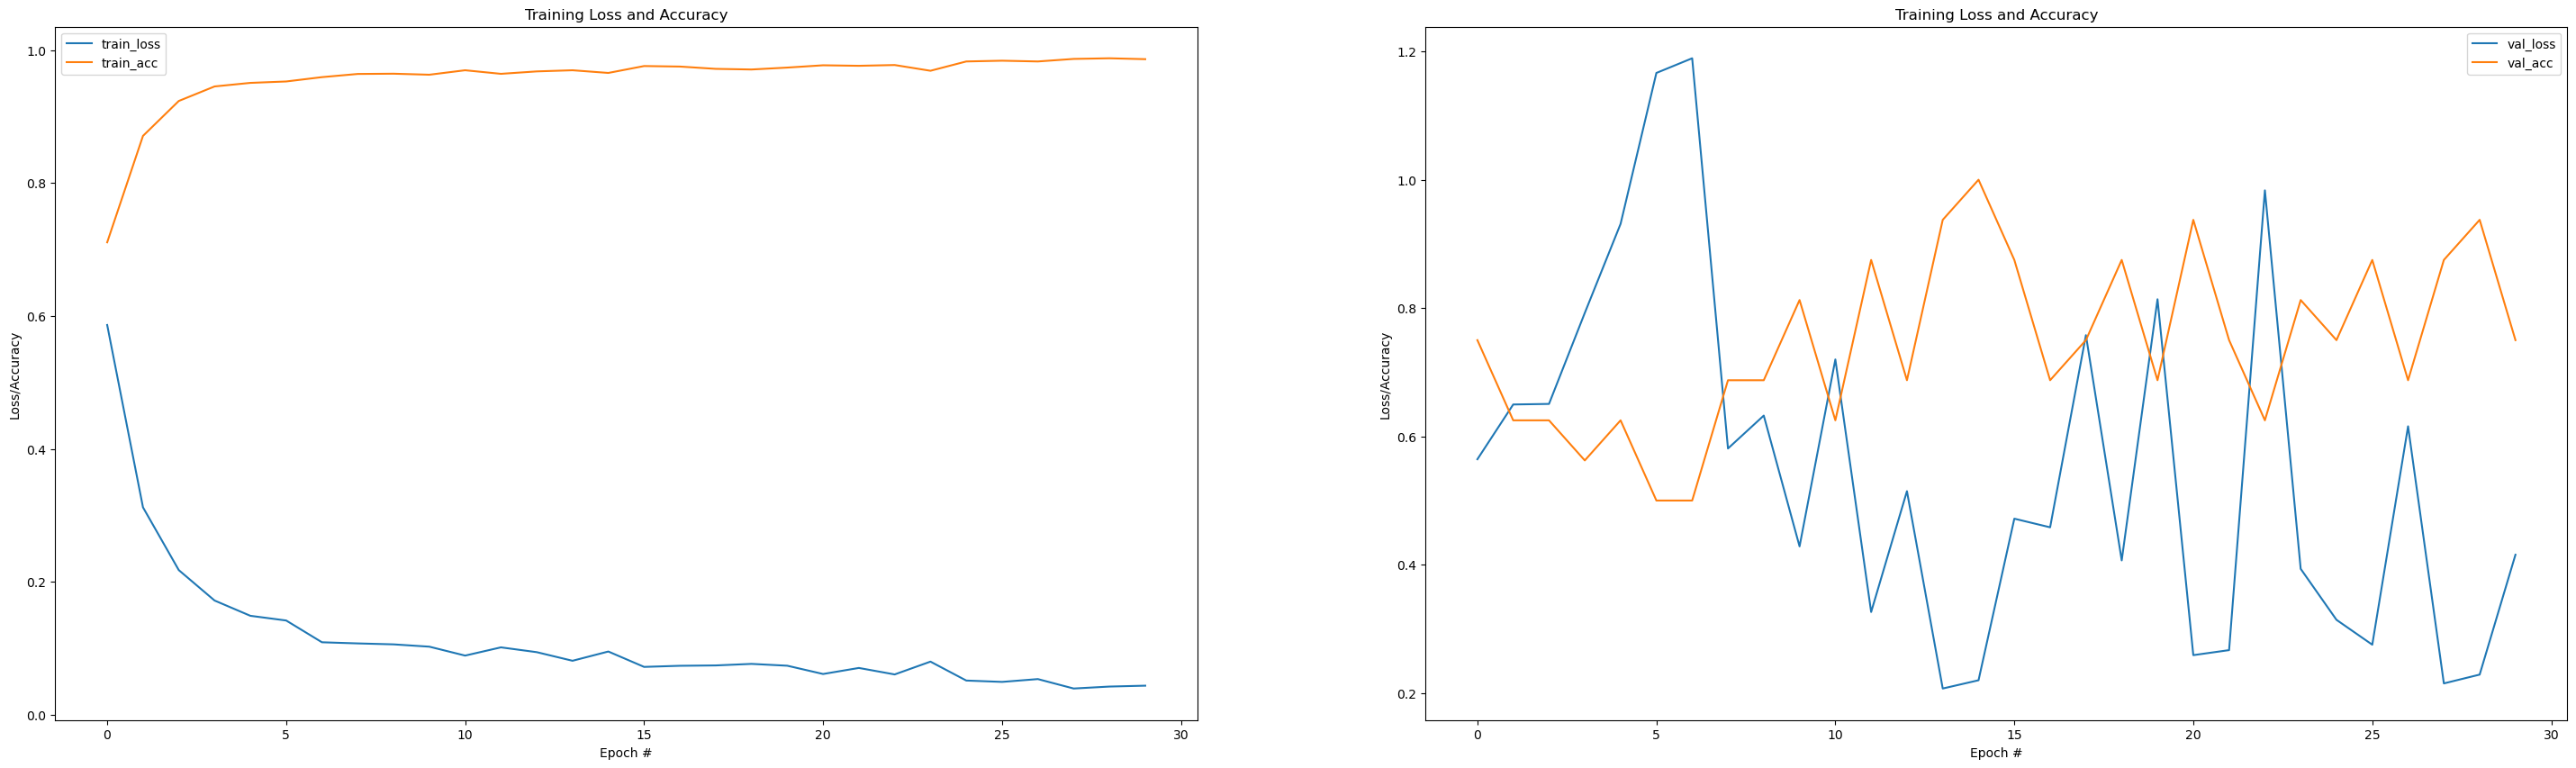

In [ ]:
# Plotting the loss and accuracy
iteration = np.arange(0, 30)

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["loss"], label="train_loss")
plt.plot(iteration, model.history.history["accuracy"], label="train_acc")
plt.legend()


ax = plt.subplot(1, 2, 2)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, model.history.history["val_loss"], label="val_loss")
plt.plot(iteration, model.history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# load the model
model_load = tf.keras.models.load_model('./augment_model/denseNet121/denseNetModel.h5')
model_load.load_weights('./augment_model/denseNet121/denseNetWeights.h5')

# Evaluate the model
loss , accuracy = model_load.evaluate(test_set)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')


print(_confusion_matrix(model_load, test_set)[1])


2023-03-24 00:08:41.766062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 19s 720ms/step - loss: 0.4658 - accuracy: 0.8494
Loss: 0.4658
Accuracy: 0.8494


2023-03-24 00:09:02.682607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-24 00:09:14.756857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      NORMAL       0.99      0.60      0.75       234
   PNEUMONIA       0.81      1.00      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.88      0.85      0.84       624



2023-03-24 00:09:23.674955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(0.0, 2.0, 2.0, 0.0)

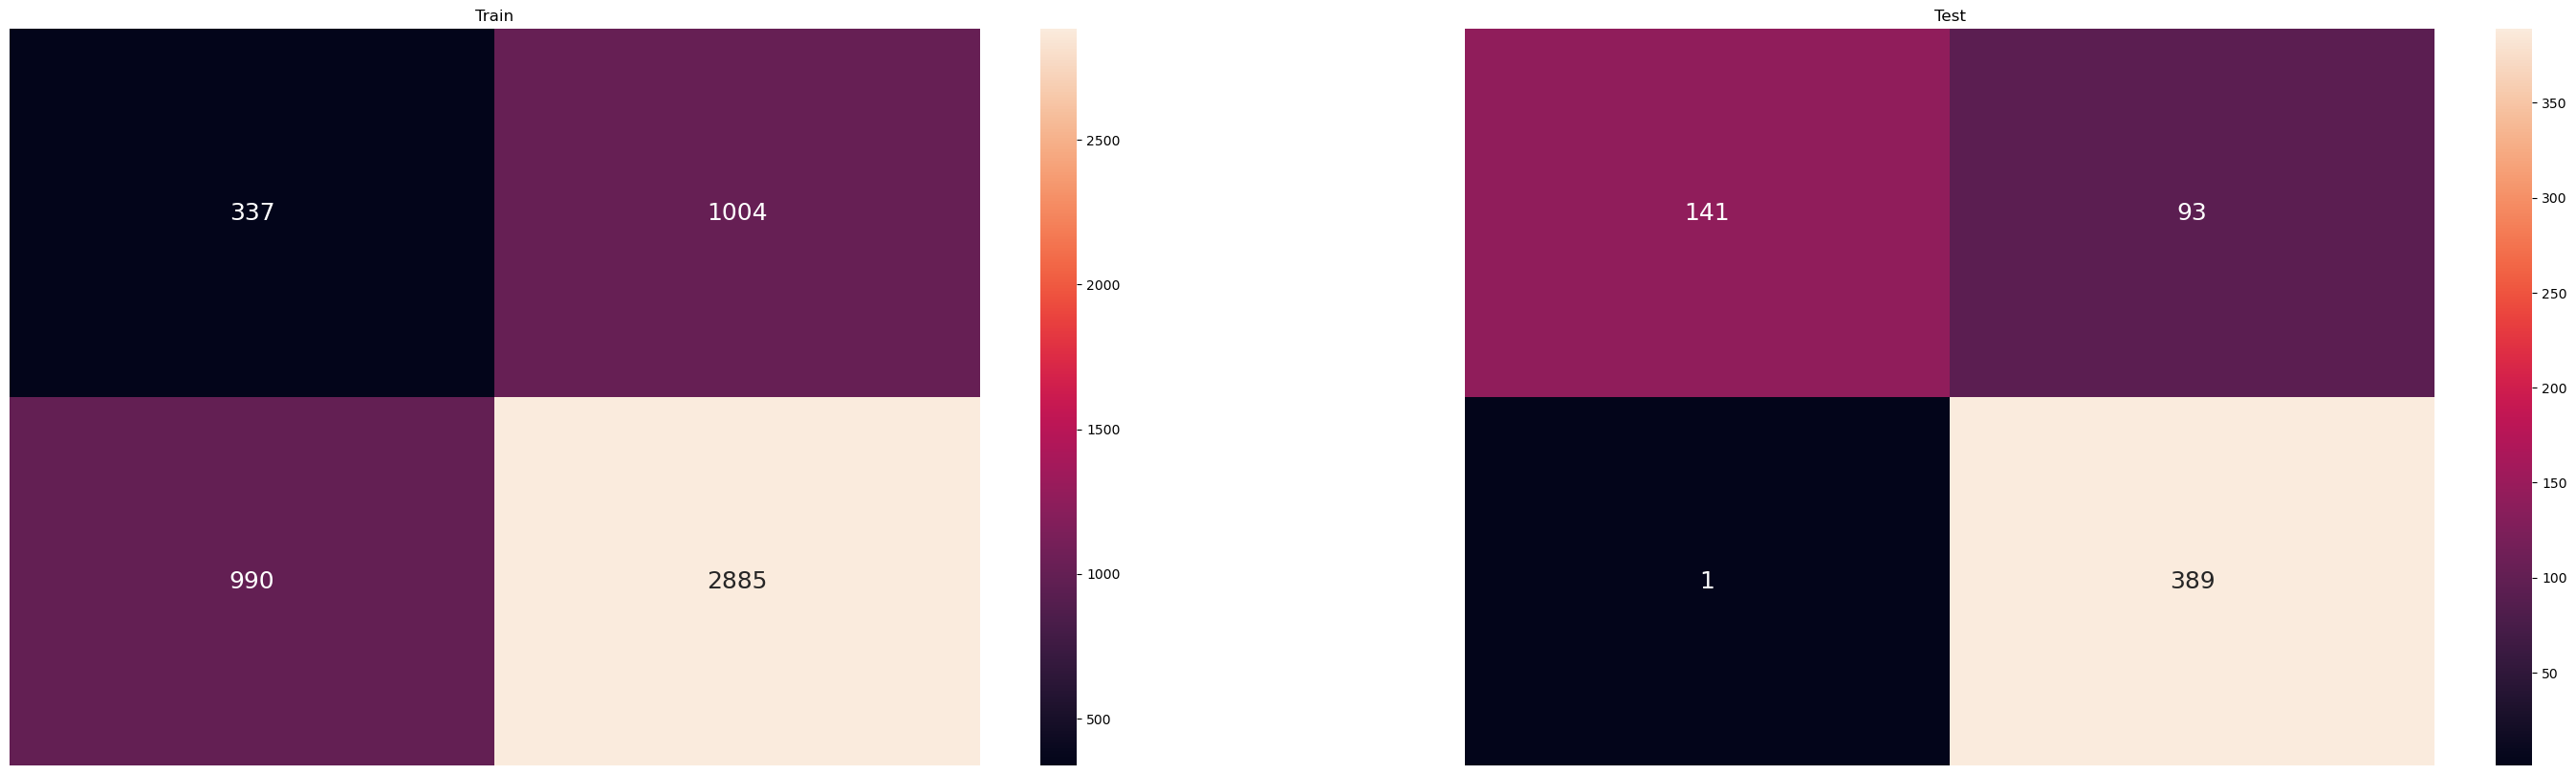

In [ ]:
# Confusion matrix

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)
plt.title("Train")
sb.heatmap(_augment_confusion_matrix(model_load, augmented_train_ds)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.title("Test")
sb.heatmap(_confusion_matrix(model_load, test_set)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

2023-03-24 00:10:25.175718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step


(-0.5, 255.5, 255.5, -0.5)

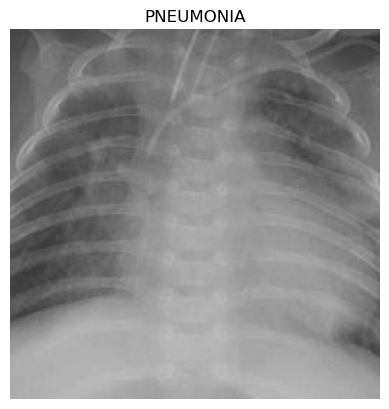

In [ ]:
image = tf.keras.utils.load_img("./crop_images/test/PNEUMONIA/person1_virus_8.jpeg.jpeg", target_size=(256, 256))

# load the model
model_load = tf.keras.models.load_model('./augment_model/denseNet121/denseNetModel.h5')
model_load.load_weights('./augment_model/denseNet121/denseNetWeights.h5')

preds = model_load.predict(np.expand_dims(image, axis=0))

i = preds.argmax(axis=1)[0]


plt.imshow(image)
plt.title(training_set.class_names[i])
plt.axis("off")